In [1]:
library(ggplot2)
library(ggseqlogo)
library(rtracklayer)
library(patchwork)

#library(ggrastr)

library(GenomicRanges)
#library(readr)
library(magrittr)
library(dplyr)

#install.packages("readr")
#BiocManager::install("ggrastr")
# install.packages("BiocManager")

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


At

In [21]:
# BiocManager::install("BSgenome.Hsapiens.UCSC.hg38")

library(BSgenome.Hsapiens.UCSC.hg38)

genome = BSgenome.Hsapiens.UCSC.hg38

In [22]:
#config = read.table("./GM12878_corrected_scaled.tsv", header=T, stringsAsFactors=F, sep='\t')
#config

#region_coorda

## Load Data

In [59]:
# one bigwig at a time, any number of peaks
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

# one bigwig at a time, any number of peaks
get_matrix_from_bigbed <- function(bigbed_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    subset_granges <- import(bigbed_path, 
      which=peak_set)
 
    # Define the range of interest, for example, chromosome 1 from 27315972 to 27367998
    chrom <- "chr1"
    region_start <- 27315972
    region_end <- 27367998
    region_length <- region_end - region_start + 1

    # Initialize a binary matrix (vector) of zeros for the specified range
    binary_matrix <- rep(0, region_length)

    # Import the BigBed file
    subset_granges <- import(bigbed_path, 
      which=peak_set)
    #subset_granges <- import(bigbed_file, which=REGION)

    subset_granges 
    # Subset the GRanges object to the range of interest

    # Check if the subset contains any features
    if (length(subset_granges) == 0) {
      stop("No features found in the specified range of interest.")
    }

    # Convert the GRanges object to a data frame for easier manipulation
    subset_df <- as.data.frame(subset_granges)

    # Define a binary matrix (vector) of zeros for the specified range
    region_length <- region_end - region_start + 1
    binary_matrix <- rep(0, region_length)

    # Iterate over each row in the dataframe to set corresponding positions in the binary matrix to 1
    for (i in 1:nrow(subset_df)) {
      # Get the start and end of the feature relative to the range of interest
      feature_start <- max(subset_df$start[i], region_start) - region_start + 1
      feature_end <- min(subset_df$end[i], region_end) - region_start + 1

      # Set the positions in the binary matrix to 1
      binary_matrix[feature_start:feature_end] <- 1
    }

    # Create a data frame for visualization
    binary_data <- data.frame(
      Position = seq(region_start, region_end),
      Presence = binary_matrix
    )

    binary_data
#     #xtract chromosome, start, and end as vectors
#     chromosome <- as.vector(seqnames(granges))  # Chromosome names
#     start_pos <- as.vector(start(granges))      # Start positions
#     end_pos <- as.vector(end(granges))          # End positions

#     # Combine extracted vectors into a matrix if needed
#     # Here, we'll use a dataframe to make it compatible with ggplot2
#     track_data <- data.frame(
#       chromosome = chromosome,
#       start = start_pos,
#       end = end_pos
#     )
    
#     track_data
}

# one bigwig, one peak (GRanges object)
get_importance_from_bigwig <- function(bigwig_path, peak, genome) {
    stopifnot(length(peak)==1)
    
    # get DNA sequence
    sequence = genome[[as.vector(seqnames(peak))]][start(peak):end(peak)]
    
    m = matrix(0, length(sequence), 4)
    colnames(m) = c("A", "C", "G", "T")
    m[cbind(seq(length(sequence)), as.vector(matrix(sequence)))] = get_matrix_from_bigwig(bigwig_path, peak)

    t(m)
}

In [60]:
GRangesFromDataFrames<-function(dataframe){with(dataframe,GRanges(IRanges(start=start,end=end),seqnames=seqnames,strand=strand,dataframe%>%dplyr::select(-strand,-start,-end,-seqnames)))}

calculate_total_value_and_length <- function(bw_path,region){
    total_value = as.integer(sum(as.vector(get_matrix_from_bigwig(bw_path, region))))
    length = length(as.vector(get_matrix_from_bigwig(bw_path, region)))
    df = data.frame(total_value=total_value,length=length)
    df
}

calculate_normalization_value <- function(bw_path,peaks_path,mc.cores=40){
        peaks_df = read_tsv(peaks_path,
                         col_names=c("seqnames","start","end","name","score","strand","p","q","x","summit"),
                         show_col_types = FALSE)
        peaks_df['strand']<-'*'
        valid_chrs = c('chr1',"chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
                                 "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20",
                                 "chr21","chrX","chrY")
        peaks_df[peaks_df[["seqnames"]] %in% valid_chrs,]
        peaks_gr = GRangesFromDataFrames(peaks_df)

        peaks_gr = keepSeqlevels(peaks_gr, c('chr1',"chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
                                 "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20",
                                 "chr21","chrX"), pruning.mode="coarse")

        print(bw_path)
        1:length(peaks_gr) %>% mclapply(function(i){
                                        calculate_total_value_and_length(bw_path,peaks_gr[i])
                                        },mc.cores=mc.cores
                                        ) %>% bind_rows() -> normalization_df

        sum(normalization_df["total_value"])/sum(normalization_df["length"])
}



## Plot types

In [50]:
TITLE_SZ = 16

### Importance

In [51]:
plot_seq <- function(m, ymin=NULL, ymax=NULL, clip=F) {
    mat = m
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            mat[mat<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            mat[mat>ymax] = ymax
        }
    }
    

    p = ggseqlogo(mat, method='custom', seq_type='dna') 
    
    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(ymin, ymax)) + 
         expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=c(ymin, ymax)) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p = p + theme(axis.ticks.y = element_blank(),axis.text.y = element_blank())

    p
}

plot_importance <- function(bigwig_path, region, genome, ylabel, ymin=NULL, ymax=NULL, clip=F) {
    plot_seq(get_importance_from_bigwig(bigwig_path, region, genome), ymin=ymin, ymax=ymax, clip=clip) +
        ylab(gsub("\\\\n", "\n", ylabel)) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5, vjust=0.5))
}

### Single Track

In [52]:
#library(ggrastr)

plot_single_vals <- function(v, ymin=NULL, ymax=NULL, 
                             clip=F, fill=T, 
                             col='#37ada2',x_width) {
    vals = v
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            vals[vals<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            vals[vals>ymax] = ymax
        }
    }
    
    p = ggplot(data.frame(x=seq(length(vals)), y=vals), aes(x=x,y=y)) 
    
    if (fill==T) {
        p = p + ggrastr::rasterise(geom_area(fill=col))
        
        p = p + ggrastr::rasterise(geom_line(col=col))

    }
    
    else {
        p = p + geom_line(col=col)
    }
    
    p = (p + 
         theme_classic() + 
         #coord_cartesian(ylim=c(0, ceiling(max(vals)))) + 
         expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=pretty(c(0, max(vals)),n=2,min.n=1)) +
         #scale_y_continuous(breaks=c(0, ceiling(max(vals)))) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p = p + theme(axis.text.y = element_text(size=14))
    
    p
}

plot_single <- function(bigwig_path, region, 
                        ylabel, ymin=NULL, ymax=NULL, 
                        fill=T, col='#37ada2', clip=F,
                        normalize = FALSE,normalization_value=None, normalization_region,normalization_file) {
    v1 = as.vector(get_matrix_from_bigwig(bigwig_path, region))
    if (normalize){
        #normalization_value = calculate_normalization_value(normalization_file,normalization_region)
        print(max(v1))
        print(normalization_value)
        v1=(v1/normalization_value)
        print(max(v1))
    }
    plot_single_vals(v1, ymin=ymin, ymax=ymax, clip=clip, fill=fill, col=col, x_width=width(region)) +
        ylab(gsub("\\\\n", "\n", ylabel)) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5,  vjust=0.5))
}

In [91]:
## scale
plot_bigbed <- function(bigbed_path, region, 
                        ylabel, ymin=NULL, ymax=NULL, 
                        fill=T, col='#37ada2', clip=F,
                        normalize = FALSE,normalization_value=None, normalization_region,normalization_file) {
    v1 = get_matrix_from_bigbed(bigbed_path, region)

    ggplot(v1, aes(x = Position, y = Presence)) +
    #geom_line(color = "steelblue") +
    ggrastr::rasterise(geom_area(fill="steelblue")) +
    theme_classic() +
    #expand_limits(x=0, y=0) +
    theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()) 

#     # Plot using ggplot2
#     ggplot(v1) +
#       geom_segment(aes(x = start, xend = end, y = chromosome, yend = chromosome),
#                size = 1, color = "steelblue") +
#       #labs(title = "Genomic Track Visualization", x = "Genomic Position", y = "Chromosome") +
#       theme_classic() +
#       theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
#       #coord_cartesian(expand = FALSE)
    
}

In [92]:
plot_scale_vals <- function(v, col='#a9d1ac') {
    vals = v
    
    p = ggplot(data.frame(x=seq(length(vals)), y=0), aes(x=x,y=y)) 
    
   
    p = p + geom_line(col=col)

    p = (p + 
         theme_classic() + 
         expand_limits(x=0, y=0) +
         scale_x_continuous(breaks=pretty(c(0, length(vals)/10),n=2,min.n=1)) +
         theme(axis.ticks.y = element_blank(), axis.text.y = element_blank(),axis.title = element_blank(),axis.line.y = element_blank())
        ) 
    
    p
}

plot_scale <- function(bigwig_path, region, ylabel, ymin=NULL, ymax=NULL, fill=T, col='#37ada2', clip=F) {
    plot_scale_vals(as.vector(get_matrix_from_bigwig(bigwig_path, region)), col=col) +
        ylab(ylabel) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5, vjust=0.5))
}

### Stranded Track

In [55]:
plot_stranded_vals <- function(v1, v2, ymin=NULL, 
                               ymax=NULL, clip=F, 
                               col1='blue', col2='orange') {
    vals1 = v1
    vals2 = v2
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            vals1[vals1<ymin] = ymin
            vals2[vals2<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            vals1[vals1>ymax] = ymax
            vals2[vals2>ymax] = ymax
        }
    }
    
    p = ggplot(data.frame(x=seq(length(vals1)), y1=vals1, y2=vals2)) +
        geom_area(aes(x=x, y=y1), fill=col1, alpha = 0.8) +
        geom_area(aes(x=x, y=y2), fill=col2, alpha = 0.8) 

    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(ymin, ymax)) + 
         expand_limits(x=0, y=0) +
         scale_y_continuous(breaks=pretty(c(0, max(max(vals1),max(vals2))),n=2,min.n=1)) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p

}

plot_stranded <- function(bigwig_prefix, region, ylabel, ymin=NULL, ymax=NULL,
                          clip=F, col1='blue', col2='orange',
                          normalize = FALSE,normalization_region,normalization_file_prefix) {
    # plus and minus should be bigwig_prefix + "plus.bw" and bigwig_prefix + "minus.bw"
    
    v1 = as.vector(get_matrix_from_bigwig(paste(bigwig_prefix, "pos.bw", sep='') , region))
    v2 = as.vector(get_matrix_from_bigwig(paste(bigwig_prefix, "neg.bw", sep='') , region))
    if (normalize){
        normalization_value = calculate_normalization_value(paste(normalization_file_prefix, "pos.bw", sep=''),normalization_region)
        v1=(v1/normalization_value)
    } 
    if (normalize){
        normalization_value = calculate_normalization_value(paste(normalization_file_prefix, "neg.bw", sep=''),normalization_region)
        v2=(v2/normalization_value)
    } 
    plot_stranded_vals(v1, v2, ymin=ymin, ymax=ymax, clip=clip, col1=col1, col2=col2) + 
        ylab(ylabel) + 
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0))
}

## Generate plots from config

In [56]:
#my_list <- list("#E00FEE", "#E00FEE", "#7B241C", "red", "#4A235A", "#4A235A", "#239B56", "blue")
#my_list <- list("#4A235A", "#4A235A", "#239B56", "blue")
#my_list <- list("#E00FEE", "#E00FEE", "null", "#458B00", "null", "#0000FF", "null", "#A52A2A", "null", "#A52A2A", "null", "#A52A2A", "null")

generate_plots <- function(config, region, genome) {
    plots = list()
    
    # configure for different relative heights for single, stranded and dynseq tracks
    REL_HEIGHTS = c(single=1, stranded=1, dynseq=1.5, scale =0.5)
    
    heights = c()
    
    for (i in seq(nrow(config))) {
        print(config$sample[i])
        if (config$type[i] == "dynseq") {
            plots[[i]] = plot_importance(config$path[i], region, genome, config$sample[i], ymin=as.double(config$Min[i]), ymax=as.double(config$Max[i]), clip=T)            
        }
        
        else if (config$type[i] == "single") {
            #print(i)
            #print(my_list[i])
            #print(paste("#",config$Color[i],sep=""))
            plots[[i]] = plot_single(config$path[i], region, 
                                     config$sample[i],
                                     col=paste("#",config$Color[i],sep=""),
                                     normalization_value=as.double(config$Scale[i]),
                                     normalize=config$normalize[i],
                                     normalization_region=config$normalization_region[i],
                                     normalization_file=config$normalization_file[i]
                                    )
            
        }
        
        else if (config$type[i] == "stranded") {
            plots[[i]] = plot_stranded(config$path[i], region, config$sample[i],
                                     normalize=config$normalize[i],
                                     normalization_region=config$normalization_region[i],
                                     normalization_file=config$normalization_file[i])
        }
        else if (config$type[i] == "scale") {
            plots[[i]] = plot_scale(config$path[i], region, config$sample[i])
        }
        
        
        else if (config$type[i] == "bigbed") {
            #print(i)
            #print(my_list[i])
            #print(paste("#",config$Color[i],sep=""))
            plots[[i]] = plot_bigbed(config$path[i], region, 
                                     config$sample[i],
                                     col=paste("#",config$Color[i],sep=""),
                                     normalization_value=as.double(config$Scale[i]),
                                     normalize=config$normalize[i],
                                     normalization_region=config$normalization_region[i],
                                     normalization_file=config$normalization_file[i]
                                    )
            
        }
        
        heights = c(heights, REL_HEIGHTS[config$type[i]])        
        
    }
    
    main = wrap_plots(plots, heights=heights)
    main
}

## Plotting
    

In [64]:
#config = read.table("./configs/config_main_locus_2_dnase.tsv", header=T, stringsAsFactors=F, sep='\t')
config = read.table("./configs/config_main_locus_2.tsv", header=T, stringsAsFactors=F, sep='\t')

#config = read.table("./configs/config_supp_gm.tsv", header=T, stringsAsFactors=F, sep='\t')


config

sample,path,normalize,normalization_region,normalization_file,type,Min,Max,Scale,Color
<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ATAC observed,/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/K562/ATAC_temp/K562_unstranded_scaled.bw,FALSE,None,None,single,None,None,None,800000
Predicted,/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_08.22.2022_filters_512_dil_8/K562_w_bias.bw,TRUE,None,None,single,None,None,1.44070548533405,800000
Counts importance,/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_08.22.2022_filters_512_dil_8/merged.K562.counts.bw,TRUE,None,None,single,-0.008637,0.056777,0.056777,2c5b4b
Profile importance,/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_08.22.2022_filters_512_dil_8/merged.K562.profile.bw,TRUE,None,None,single,-0.006682,0.064410,0.064410,2c5b4b
spi1chip,/mnt/lab_data2/anusri/chrombpnet/src/evaluation/figure_notebooks/figure_1/bedtracks/ctcfbed/ENCFF088XXV.bigBed,TRUE,None,None,bigbed,-0.006682,0.064410,0.064410,2c5b4b
ctcfchip,/mnt/lab_data2/anusri/chrombpnet/src/evaluation/figure_notebooks/figure_1/bedtracks/ctcfbed/ENCFF095JYT.bigBed,TRUE,None,None,bigbed,-0.006682,0.064410,0.064410,2c5b4b


In [65]:
range="chr5:52799900-52800200"
#range="chr10:8083334-8083518"
#range="chr11:5280610-5280915"
#range="chr3:128503056-128503522"
cellline="IL4I1_gene_gm12878"

#range="chr19:12676469-12676618" - good
#range="chr7:101883009-101883121"
range="chr19:1512924-1513188"
range="chr1:188815478-192015493"
range="chr1:177788387-178934398"
range="chr1:178489686-178548665"
range="chr1:27218756-27370001"

#range="chr1:27365497-27365735"
#range="chr1:27357602-27357734"
#range="chr1:27332886-27333023"

range="chr1:27315972-27367998"
#range="chr1:27322051-27322272"
#range="chr1:27332886-27333023"
#range="chr1:27357602-27357734"
#range="chr1:27349460-27349618"
#range="chr1:27347262-27347525"
#range="chr1:27341884-27342124"
#range="chr1:27345000-27346005"
#- good
#range="chr17:64774227-64774382"
#range="chr12:48001585-48001699"
#range="chr1:35193116-35193239"
#range="chr17:17303269-17303362"
#range="chr12:6970664-6970945"
#range="chr16:2777242-2777424"
# above all tested for full runs

#range="chr12:77065566-77065698"
#range="chr1:226197112-226197240"
#range="chr3:25582314-25582469"
#range="chr11:8688892-8689139"
#range="chr7:102991803-102991902"
#range="chr19:12564170-12564341"
#range="chr1:27122775-27122880"
#range="chr7:102993053-102993147"
#range="chr5:32329494-32329610"
#range="chr11:60775460-60775608"
#range="chr6:13380814-13381140"
#range="chr1:27365497-27365735"
cellline="K562"
#good
#file_name = paste(paste(cellline,range,sep="_"),"dnase.pdf",sep="")
file_name = paste(paste(cellline,range,sep="_"),"atac.pdf",sep="")

file_name

[1] "K562_chr1:27315972-27367998atac.pdf"

[1] "ATAC observed"
[1] "Predicted"
[1] 87.09962
[1] 1.440705
[1] 60.45623
[1] "Counts importance"
[1] 0.0579924
[1] 0.056777
[1] 1.021407
[1] "Profile importance"
[1] 0.08517375
[1] 0.06441
[1] 1.322368
[1] "spi1chip"
[1] "ctcfchip"


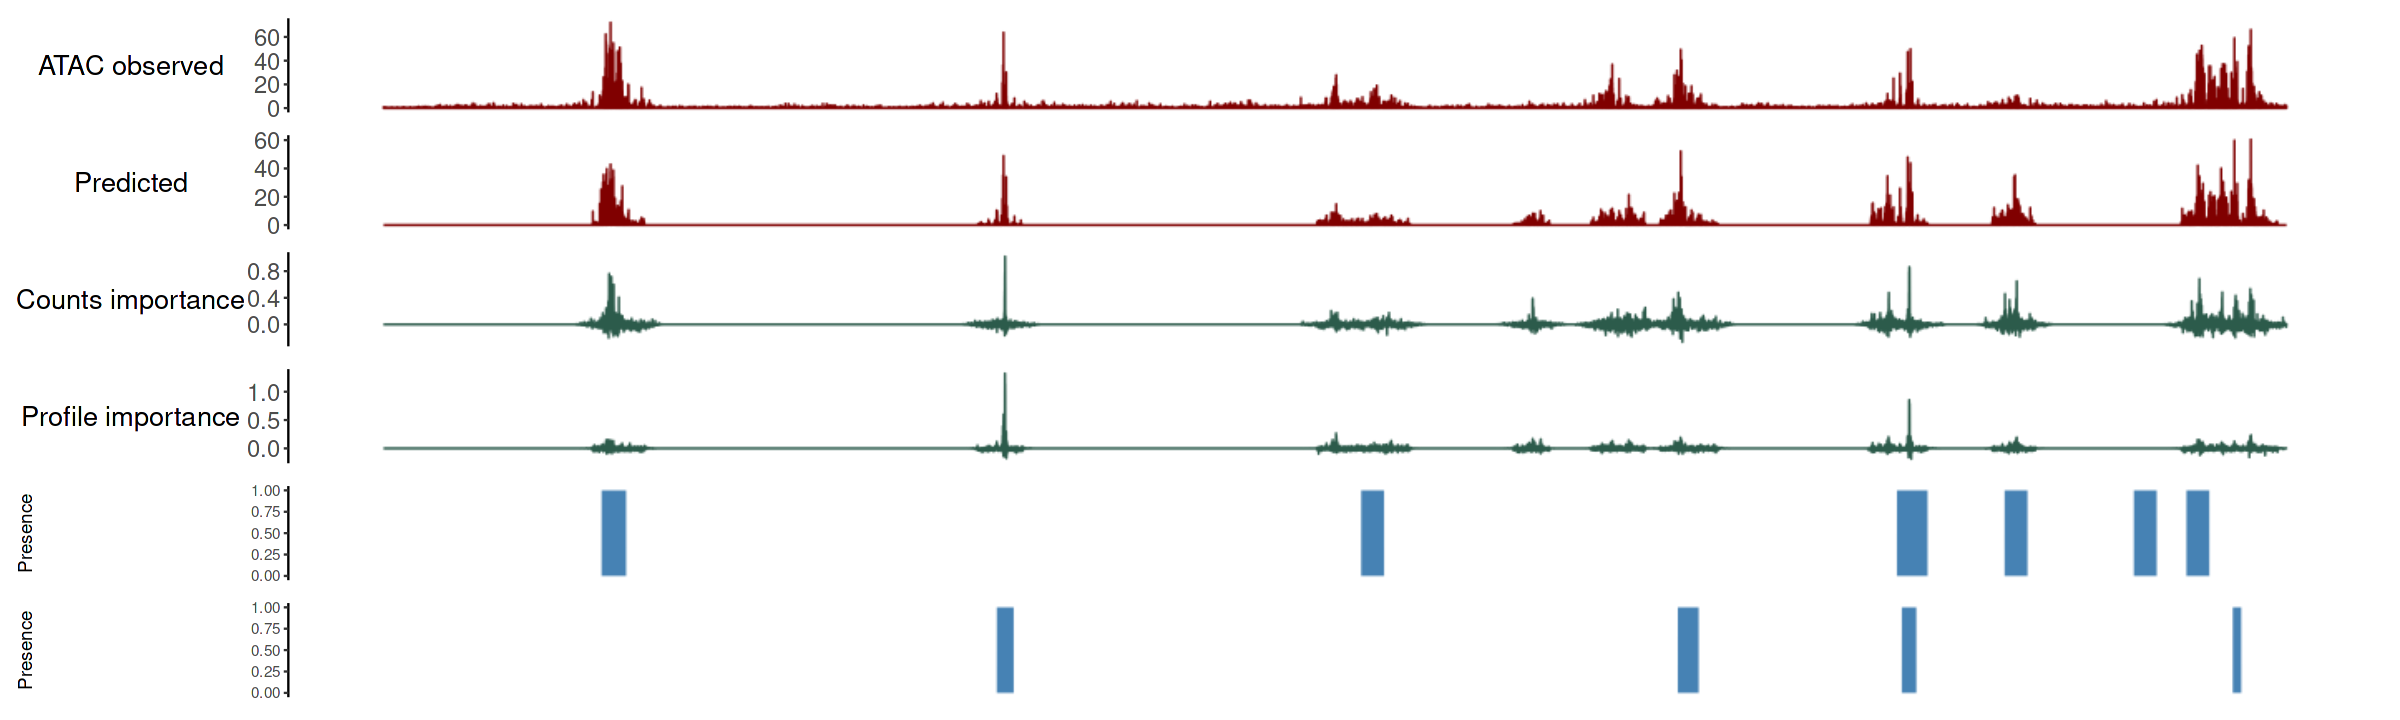

In [93]:
REGION = GRanges(range)

options(repr.plot.width = 20, repr.plot.height = nrow(config))

p = generate_plots(config, REGION, genome)

p
#ggsave(paste("subfigs/locus_plots/",file_name,sep=""), p, height=nrow(config), width=20, useDingbats=F)


In [94]:
file_name = paste(paste(cellline,range,sep="_"),"atac_with_chip.pdf",sep="")

ggsave(paste("subfigs/locus_plots/",file_name,sep=""), p, height=nrow(config), width=20, useDingbats=F)


In [27]:
#wrap_plots(ggplot() + theme_void() + annotate("segment", x=0, xend=0, y=0, yend=0.25),p,heights=c(10,10),widths=c(1,20),ncol=2)


In [59]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/libf77blas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=C             
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg38_1.4.3 BSgenome_1.58.0                  
 [3] Biostrings_2.58.0                 XVector_0.30.0                   
 [5] dplyr_1.0.9                       magrittr_2.0.3                   
 [7] readr_2.1.2          